# Project Delivery Part 2

## 1. Setup and Imports

In [2]:
# Core
import numpy as np
import pandas as pd

# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.feature_selection import VarianceThreshold

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (roc_auc_score, confusion_matrix,
                             classification_report, RocCurveDisplay, accuracy_score)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree

## 2. Data Loading

In [3]:
df_0 = pd.read_csv("period_0.csv")
df_1 = pd.read_csv("period_1_prediction.csv")

print(f"Period 0: {df_0.shape}")
print(f"Period 1: {df_1.shape}")

Period 0: (7700, 14)
Period 1: (7700, 12)


## 3. Data Inspection

In [4]:
df_0.head()

,id,age,job,marital,education,preferred_contact,balance,loan_house,loan_personal,n_marketing_contacts,marketing_potential,call_length,investment,period
0,1,31,entrepreneur,single,tertiary,cellular,38,no,no,0,unknown,185,0.00,0
1,2,29,management,married,tertiary,cellular,1022,yes,no,0,unknown,408,0.00,0
2,3,49,blue-collar,divorced,secondary,cellular,10613,no,yes,0,unknown,1226,1264.69,0
3,4,23,management,single,tertiary,cellular,736,yes,no,0,unknown,119,0.00,0
4,5,42,technician,married,secondary,NaN,-158,yes,no,0,unknown,124,0.00,0


In [5]:
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7700 entries, 0 to 7699
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    7700 non-null   int64  
 1   age                   7700 non-null   int64  
 2   job                   7657 non-null   object 
 3   marital               7700 non-null   object 
 4   education             7403 non-null   object 
 5   preferred_contact     5473 non-null   object 
 6   balance               7700 non-null   int64  
 7   loan_house            7700 non-null   object 
 8   loan_personal         7700 non-null   object 
 9   n_marketing_contacts  7700 non-null   int64  
 10  marketing_potential   7700 non-null   object 
 11  call_length           7700 non-null   int64  
 12  investment            7700 non-null   float64
 13  period                7700 non-null   int64  
dtypes: float64(1), int64(6), object(7)
memory usage: 842.3+ KB


## 4. Data Preparation

### 4.1 Creating the Target Variable

In [6]:
df_0['investment_status'] = (df_0['investment'] > 0).astype(int)

print(f"Investment Rate: {df_0['investment_status'].mean():.3f}")
print(f"\nVerteilung:")
print(df_0['investment_status'].value_counts())

Investment Rate: 0.115

Verteilung:
investment_status
0    6816
1     884
Name: count, dtype: int64


The target variable `investment_status` is a binary indicator derived from the `investment` column. A value of 1 means the client invested, 0 means they did not. This transformation is necessary because Submission 2 requires a classification approach — predicting whether a client will invest (yes/no), not the investment amount.

The results show that only 11.5% of clients invested (884 out of 7,700). This confirms that the dataset is imbalanced, which will be addressed during modeling through stratified splitting and the `class_weight` parameter.

### 4.2 Filtering Unprofitable Clients

In [7]:
# Filter: only keep clients where contact is profitable
# Break-even: 0.22 * balance * 0.045 = 5 → balance = 505
df_0 = df_0[df_0['balance'] >= 505]

print(f"After filter: {df_0.shape[0]} clients remaining")
print(f"Investment Rate after filter: {df_0['investment_status'].mean():.3f}")

After filter: 3653 clients remaining
Investment Rate after filter: 0.144


Clients with an account balance below 505 euros are removed because contacting them is not economically viable. The threshold is derived from the business model:

- Clients invest on average 22% of their balance
- Amundi earns a 4.5% commission on the invested amount
- Each outreach costs 5 euros
- Break-even: 0.22 × 505 × 0.045 ≈ 5 euros

Below this threshold, the expected revenue does not cover the contact cost. This filter is applied to both the training data and later to the Period 1 predictions to ensure only profitable clients are considered.

### 4.3 Defining Features and Target

In [8]:
# Columns to remove
drop_cols = ['investment_status', 'investment', 'id', 'period', 'call_length']

X = df_0.drop(columns=drop_cols)
y = df_0['investment_status']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns:")
print(X.columns.tolist())

Features shape: (3653, 10)
Target shape: (3653,)

Feature columns:
['age', 'job', 'marital', 'education', 'preferred_contact', 'balance', 'loan_house', 'loan_personal', 'n_marketing_contacts', 'marketing_potential']


The following columns are removed from the feature set:
- `investment_status`: This is our target variable (y) and must not be included in the features.
- `investment`: The investment amount would be data leakage — it reveals the outcome directly.
- `id`: A unique identifier with no predictive value.
- `period`: Constant value (always 0), carries no information.
- `call_length`: Not available in Period 1 and only known after contact — using it would be data leakage.

The remaining 10 features are used to predict whether a client will invest.

## 5. Train-Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nClass balance train: {y_train.mean():.3f}")
print(f"Class balance test:  {y_test.mean():.3f}")

Training set: (2922, 10)
Test set: (731, 10)

Class balance train: 0.144
Class balance test:  0.144


The original Period 0 dataset contains 7,700 clients. After filtering out clients with a balance below 505 euros, 3,653 clients remain. These are split into 80% training (2,922) and 20% test data (731). The stratify parameter ensures that the proportion of investors (~14.4%) is preserved in both sets. This is important because our data is imbalanced — without stratification, the split could be uneven, leading to unreliable evaluation results.

## 6. Preprocessing Pipeline

Machine learning models can only work with numerical data. However, our dataset contains both text-based categorical variables and missing values. The preprocessing pipeline addresses both issues in a structured and reproducible way.

In [10]:
# Categorical: fill missing → one-hot encode
categorical_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(
        min_frequency=0.05,
        handle_unknown='infrequent_if_exist',
        sparse_output=False,
        drop=None
    ))
])

# Numeric: fill missing with median
numeric_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median'))
])

# Combine both
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_pipeline, make_column_selector(dtype_include=['object', 'category'])),
        ('num', numeric_pipeline, make_column_selector(dtype_include=['number']))
    ],
    remainder='passthrough'
)

The preprocessing pipeline handles categorical and numeric variables separately. Categorical variables have missing values replaced with "missing" and are then one-hot encoded into binary columns. Rare categories (below 5%) are grouped into an "infrequent" class. Numeric variables have missing values filled with the median. No scaling is applied as Decision Trees are not affected by different feature scales. The pipeline ensures consistent preprocessing during both training and prediction.

## 7. Baseline Decision Tree

Before optimizing, a baseline model with default parameters is trained to establish a reference point.

In [11]:
pipeline_dt = Pipeline([
    ('preprocess', preprocessor),
    ('var_filter', VarianceThreshold(threshold=0.01)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Fit baseline model with default parameters
pipeline_dt.fit(X_train, y_train)

train_acc = pipeline_dt.score(X_train, y_train)
test_acc = pipeline_dt.score(X_test, y_test)

print(f"=== Baseline Decision Tree ===")
print(f"Training accuracy: {train_acc:.3f}")
print(f"Test accuracy:     {test_acc:.3f}")

=== Baseline Decision Tree ===
Training accuracy: 1.000
Test accuracy:     0.751


The baseline model shows strong overfitting: training accuracy is 100% but test accuracy only 75.1%. The model memorizes training data instead of learning general patterns. A naive model predicting "no investment" for everyone would already achieve 85.6% accuracy, so the baseline barely adds value. Hyperparameter tuning will address this.

## 8. Hyperparameter Tuning with GridSearchCV

In [12]:
parameters = {
    'var_filter__threshold': [0.01, 0.05],
    'classifier__max_depth': [3, 4, 5, 6, 8],
    'classifier__min_samples_split': [2, 5, 10, 20],
    'classifier__min_samples_leaf': [1, 2, 4, 8],
    'classifier__class_weight': ['balanced', None]
}

cv = GridSearchCV(
    pipeline_dt,
    parameters,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

cv.fit(X_train, y_train)

print(f"\nBest parameters: {cv.best_params_}")
print(f"Best CV ROC-AUC: {cv.best_score_:.3f}")

Fitting 5 folds for each of 320 candidates, totalling 1600 fits

Best parameters: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 20, 'var_filter__threshold': 0.05}
Best CV ROC-AUC: 0.724


GridSearchCV tested 320 parameter combinations across 5 folds (1,600 fits total). The best model uses max_depth=5, which limits tree complexity and reduces overfitting compared to the unlimited baseline. The class_weight "balanced" helps the model better detect investors despite the data imbalance. The best cross-validated ROC-AUC of 0.724 confirms the model performs significantly better than random guessing (0.5).

## 9. Decision Tree Evaluation

In [13]:
y_pred = cv.predict(X_test)
y_prob = cv.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_prob)

print(f"=== Optimized Decision Tree ===")
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Test ROC-AUC:  {test_auc:.3f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Investment', 'Investment']))

print(f"\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(pd.DataFrame(cm,
    index=['Actual: No', 'Actual: Yes'],
    columns=['Predicted: No', 'Predicted: Yes']))

=== Optimized Decision Tree ===
Test Accuracy: 0.756
Test ROC-AUC:  0.704

Classification Report:
               precision    recall  f1-score   support

No Investment       0.90      0.80      0.85       626
   Investment       0.29      0.49      0.36       105

     accuracy                           0.76       731
    macro avg       0.60      0.64      0.61       731
 weighted avg       0.82      0.76      0.78       731


Confusion Matrix:
             Predicted: No  Predicted: Yes
Actual: No             502             124
Actual: Yes             54              51


The optimized Decision Tree achieves a test ROC-AUC of 0.704 and detects 49% of actual investors (Recall). Out of 105 real investors, 51 were correctly identified and 54 were missed. Every missed investor means lost revenue, so additional models will be compared to improve performance.

## 10. Logistic Regression

Logistic Regression is tested as an alternative to the Decision Tree. Unlike trees, it requires feature scaling, so a StandardScaler is added to the numeric pipeline.

In [14]:
from sklearn.preprocessing import StandardScaler

# New numeric pipeline WITH scaling (needed for Logistic Regression)
numeric_pipeline_scaled = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

# New preprocessor with scaling
preprocessor_scaled = ColumnTransformer(
    transformers=[
        ('cat', categorical_pipeline, make_column_selector(dtype_include=['object', 'category'])),
        ('num', numeric_pipeline_scaled, make_column_selector(dtype_include=['number']))
    ],
    remainder='passthrough'
)

# Logistic Regression pipeline
pipeline_lr = Pipeline([
    ('preprocess', preprocessor_scaled),
    ('var_filter', VarianceThreshold(threshold=0.01)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# GridSearchCV for Logistic Regression
params_lr = {
    'var_filter__threshold': [0.01, 0.05],
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__class_weight': ['balanced', None]
}

cv_lr = GridSearchCV(
    pipeline_lr,
    params_lr,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

cv_lr.fit(X_train, y_train)

print(f"\nBest parameters: {cv_lr.best_params_}")
print(f"Best CV ROC-AUC: {cv_lr.best_score_:.3f}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters: {'classifier__C': 0.1, 'classifier__class_weight': None, 'var_filter__threshold': 0.01}
Best CV ROC-AUC: 0.744


Unlike Decision Trees, Logistic Regression requires scaled features because it is sensitive to different value ranges. The parameter C controls regularization — smaller values create a simpler model that is less likely to overfit. GridSearchCV finds the best combination using 5-fold cross-validation.

### 10.1 Logistic Regression Evaluation

In [15]:
y_pred_lr = cv_lr.predict(X_test)
y_prob_lr = cv_lr.predict_proba(X_test)[:, 1]

test_accuracy_lr = accuracy_score(y_test, y_pred_lr)
test_auc_lr = roc_auc_score(y_test, y_prob_lr)

print(f"=== Optimized Logistic Regression ===")
print(f"Test Accuracy: {test_accuracy_lr:.3f}")
print(f"Test ROC-AUC:  {test_auc_lr:.3f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['No Investment', 'Investment']))

print(f"\nConfusion Matrix:")
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(pd.DataFrame(cm_lr,
    index=['Actual: No', 'Actual: Yes'],
    columns=['Predicted: No', 'Predicted: Yes']))

=== Optimized Logistic Regression ===
Test Accuracy: 0.855
Test ROC-AUC:  0.710

Classification Report:
               precision    recall  f1-score   support

No Investment       0.86      0.99      0.92       626
   Investment       0.47      0.08      0.13       105

     accuracy                           0.85       731
    macro avg       0.67      0.53      0.53       731
 weighted avg       0.81      0.85      0.81       731


Confusion Matrix:
             Predicted: No  Predicted: Yes
Actual: No             617               9
Actual: Yes             97               8


The Logistic Regression achieves a higher accuracy (85.5%) but a very low Recall of only 8% — it detects just 8 out of 105 real investors. The high accuracy is misleading because the model almost always predicts "no investment", which is correct for 85.6% of clients but useless for identifying investors. The Decision Tree (Recall 49%) is more suitable for our business goal of finding potential investors.

## 11. Random Forest

A Random Forest combines many Decision Trees and averages their predictions. This typically reduces overfitting and improves performance compared to a single tree.

In [16]:
# Random Forest pipeline (no scaling needed, like Decision Tree)
pipeline_rf = Pipeline([
    ('preprocess', preprocessor),
    ('var_filter', VarianceThreshold(threshold=0.01)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# GridSearchCV
params_rf = {
    'var_filter__threshold': [0.01, 0.05],
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 8, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__class_weight': ['balanced', None]
}

cv_rf = GridSearchCV(
    pipeline_rf,
    params_rf,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

cv_rf.fit(X_train, y_train)

print(f"\nBest parameters: {cv_rf.best_params_}")
print(f"Best CV ROC-AUC: {cv_rf.best_score_:.3f}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits

Best parameters: {'classifier__class_weight': None, 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 4, 'classifier__n_estimators': 200, 'var_filter__threshold': 0.01}
Best CV ROC-AUC: 0.754


The Random Forest has similar parameters to the Decision Tree, plus n_estimators which controls how many trees are combined. More trees generally improve performance but increase computation time.

### 11.1 Random Forest Evaluation

In [17]:
y_pred_rf = cv_rf.predict(X_test)
y_prob_rf = cv_rf.predict_proba(X_test)[:, 1]

test_accuracy_rf = accuracy_score(y_test, y_pred_rf)
test_auc_rf = roc_auc_score(y_test, y_prob_rf)

print(f"=== Optimized Random Forest ===")
print(f"Test Accuracy: {test_accuracy_rf:.3f}")
print(f"Test ROC-AUC:  {test_auc_rf:.3f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['No Investment', 'Investment']))

print(f"\nConfusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(pd.DataFrame(cm_rf,
    index=['Actual: No', 'Actual: Yes'],
    columns=['Predicted: No', 'Predicted: Yes']))

=== Optimized Random Forest ===
Test Accuracy: 0.858
Test ROC-AUC:  0.715

Classification Report:
               precision    recall  f1-score   support

No Investment       0.87      0.99      0.92       626
   Investment       0.53      0.09      0.15       105

     accuracy                           0.86       731
    macro avg       0.70      0.54      0.53       731
 weighted avg       0.82      0.86      0.81       731


Confusion Matrix:
             Predicted: No  Predicted: Yes
Actual: No             618               8
Actual: Yes             96               9


The Random Forest achieves the highest ROC-AUC (0.715) but, like Logistic Regression, detects very few investors (Recall = 9%). However, ROC-AUC is the most relevant metric for our use case because we do not need hard yes/no predictions — we only need to rank clients by their probability of investing and select the top 1,200.

## 12. Model Comparison

In [18]:
comparison = pd.DataFrame({
    'Model': ['Decision Tree', 'Logistic Regression', 'Random Forest'],
    'Accuracy': [test_accuracy, test_accuracy_lr, test_accuracy_rf],
    'ROC-AUC': [test_auc, test_auc_lr, test_auc_rf],
    'Recall Investment': [0.49, 0.08, 0.09],
    'Investors Found': [51, 8, 9]
})

print(comparison.to_string(index=False))

              Model  Accuracy  ROC-AUC  Recall Investment  Investors Found
      Decision Tree  0.756498 0.704085               0.49               51
Logistic Regression  0.854993 0.710391               0.08                8
      Random Forest  0.857729 0.715488               0.09                9


The three models were compared using ROC-AUC, accuracy, and recall. The Random Forest achieves the highest ROC-AUC (0.715), followed by Logistic Regression (0.710) and the Decision Tree (0.704). While the Decision Tree finds the most investors in absolute terms (51 out of 105), its ROC-AUC is the lowest of the three.

For our business case, ROC-AUC is the most relevant metric. We do not need hard yes/no predictions — instead, we rank all clients by their predicted probability of investing and select the top 1,200. A higher ROC-AUC means the model is better at placing real investors at the top of this ranking.

Based on this comparison, the Random Forest is selected as the final model for the Period 1 prediction.

## 13. Visualizations

### 13.1 ROC Curve Comparison

<Figure size 800x600 with 0 Axes>

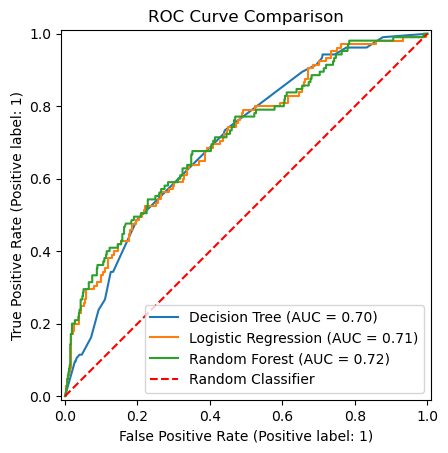

In [19]:
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(cv, X_test, y_test, name='Decision Tree')
RocCurveDisplay.from_estimator(cv_lr, X_test, y_test, name='Logistic Regression', ax=plt.gca())
RocCurveDisplay.from_estimator(cv_rf, X_test, y_test, name='Random Forest', ax=plt.gca())
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

The ROC curves show how well each model separates investors from non-investors. The further the curve is from the red diagonal (random guessing), the better the model. The Random Forest curve is slightly above the others, confirming it as the best model.

### 13.2 Feature Importance (Random Forest)

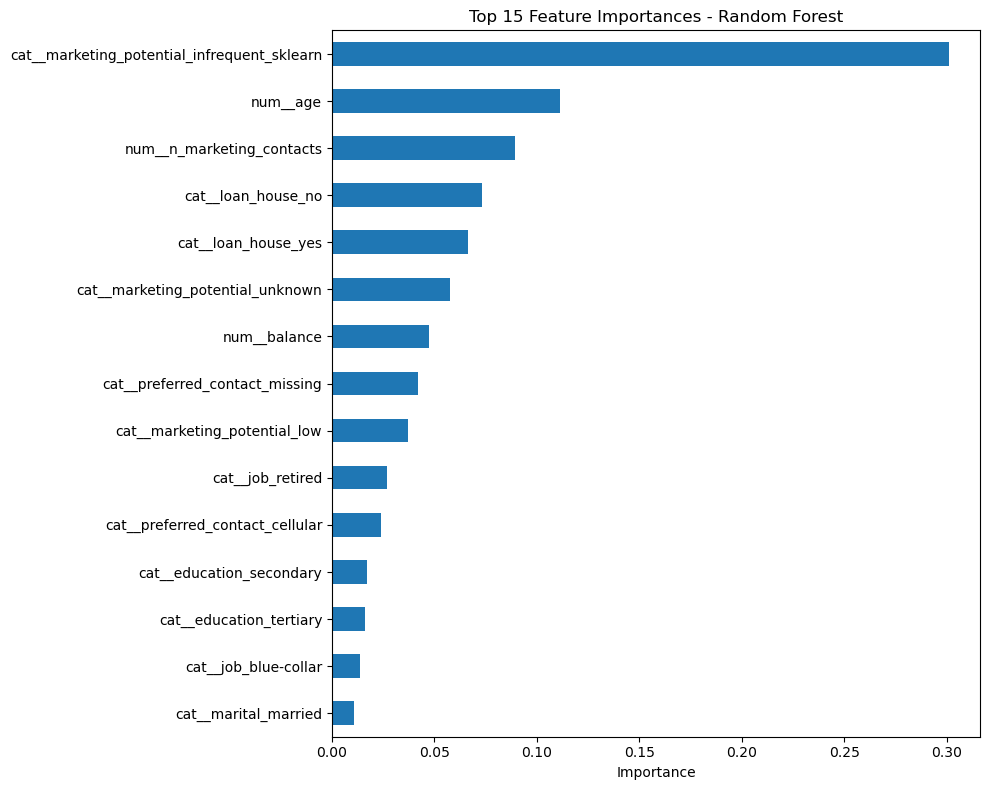

In [20]:
best_rf = cv_rf.best_estimator_.named_steps['classifier']

feature_names_all = cv_rf.best_estimator_.named_steps['preprocess'].get_feature_names_out()
variance_mask = cv_rf.best_estimator_.named_steps['var_filter'].get_support()
selected_features = feature_names_all[variance_mask]

importances = pd.Series(best_rf.feature_importances_, index=selected_features)
importances = importances.sort_values(ascending=True)

plt.figure(figsize=(10, 8))
importances.tail(15).plot(kind='barh')
plt.title('Top 15 Feature Importances - Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

Feature importance shows which variables the Random Forest relies on most for predicting investment behavior. Higher values indicate stronger influence on the prediction.

### 13.3 Confusion Matrix Heatmap

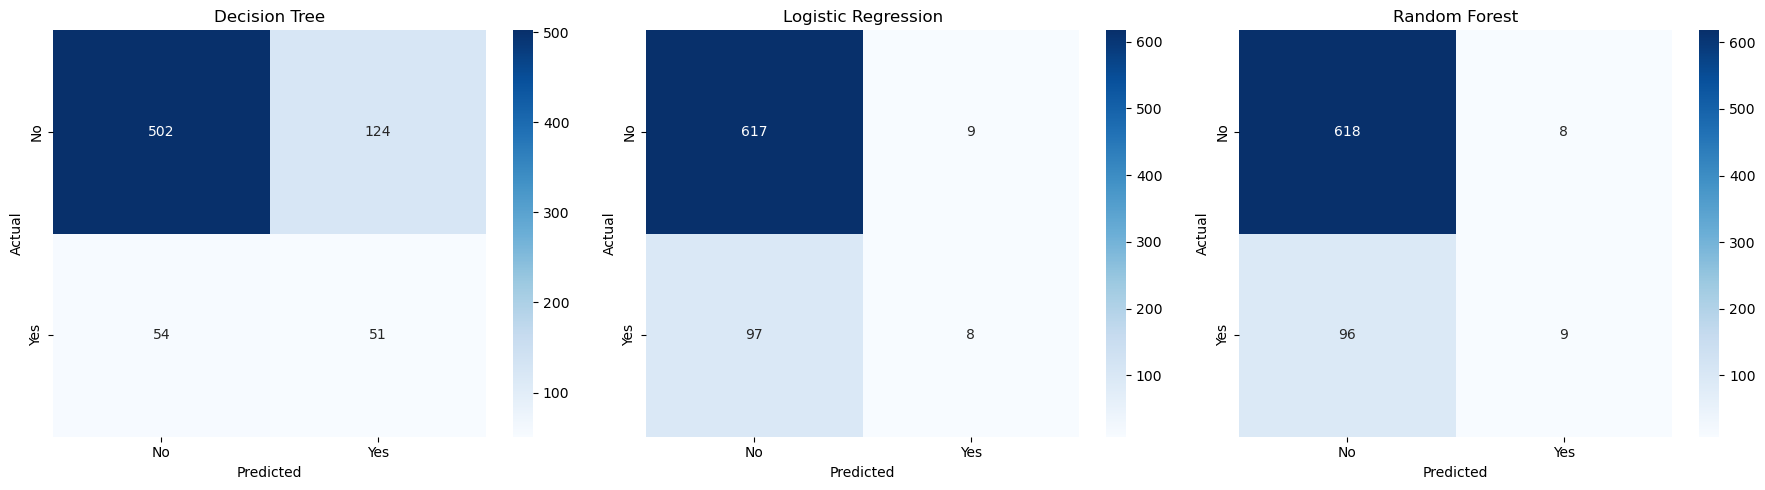

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, cm_data, title in zip(axes, 
    [cm, cm_lr, cm_rf], 
    ['Decision Tree', 'Logistic Regression', 'Random Forest']):
    sns.heatmap(cm_data, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

The confusion matrix heatmaps compare all three models side by side. The Decision Tree shows a more balanced distribution between classes, while Logistic Regression and Random Forest heavily favor the majority class (No Investment).

### 13.4 Decision Tree Visualization

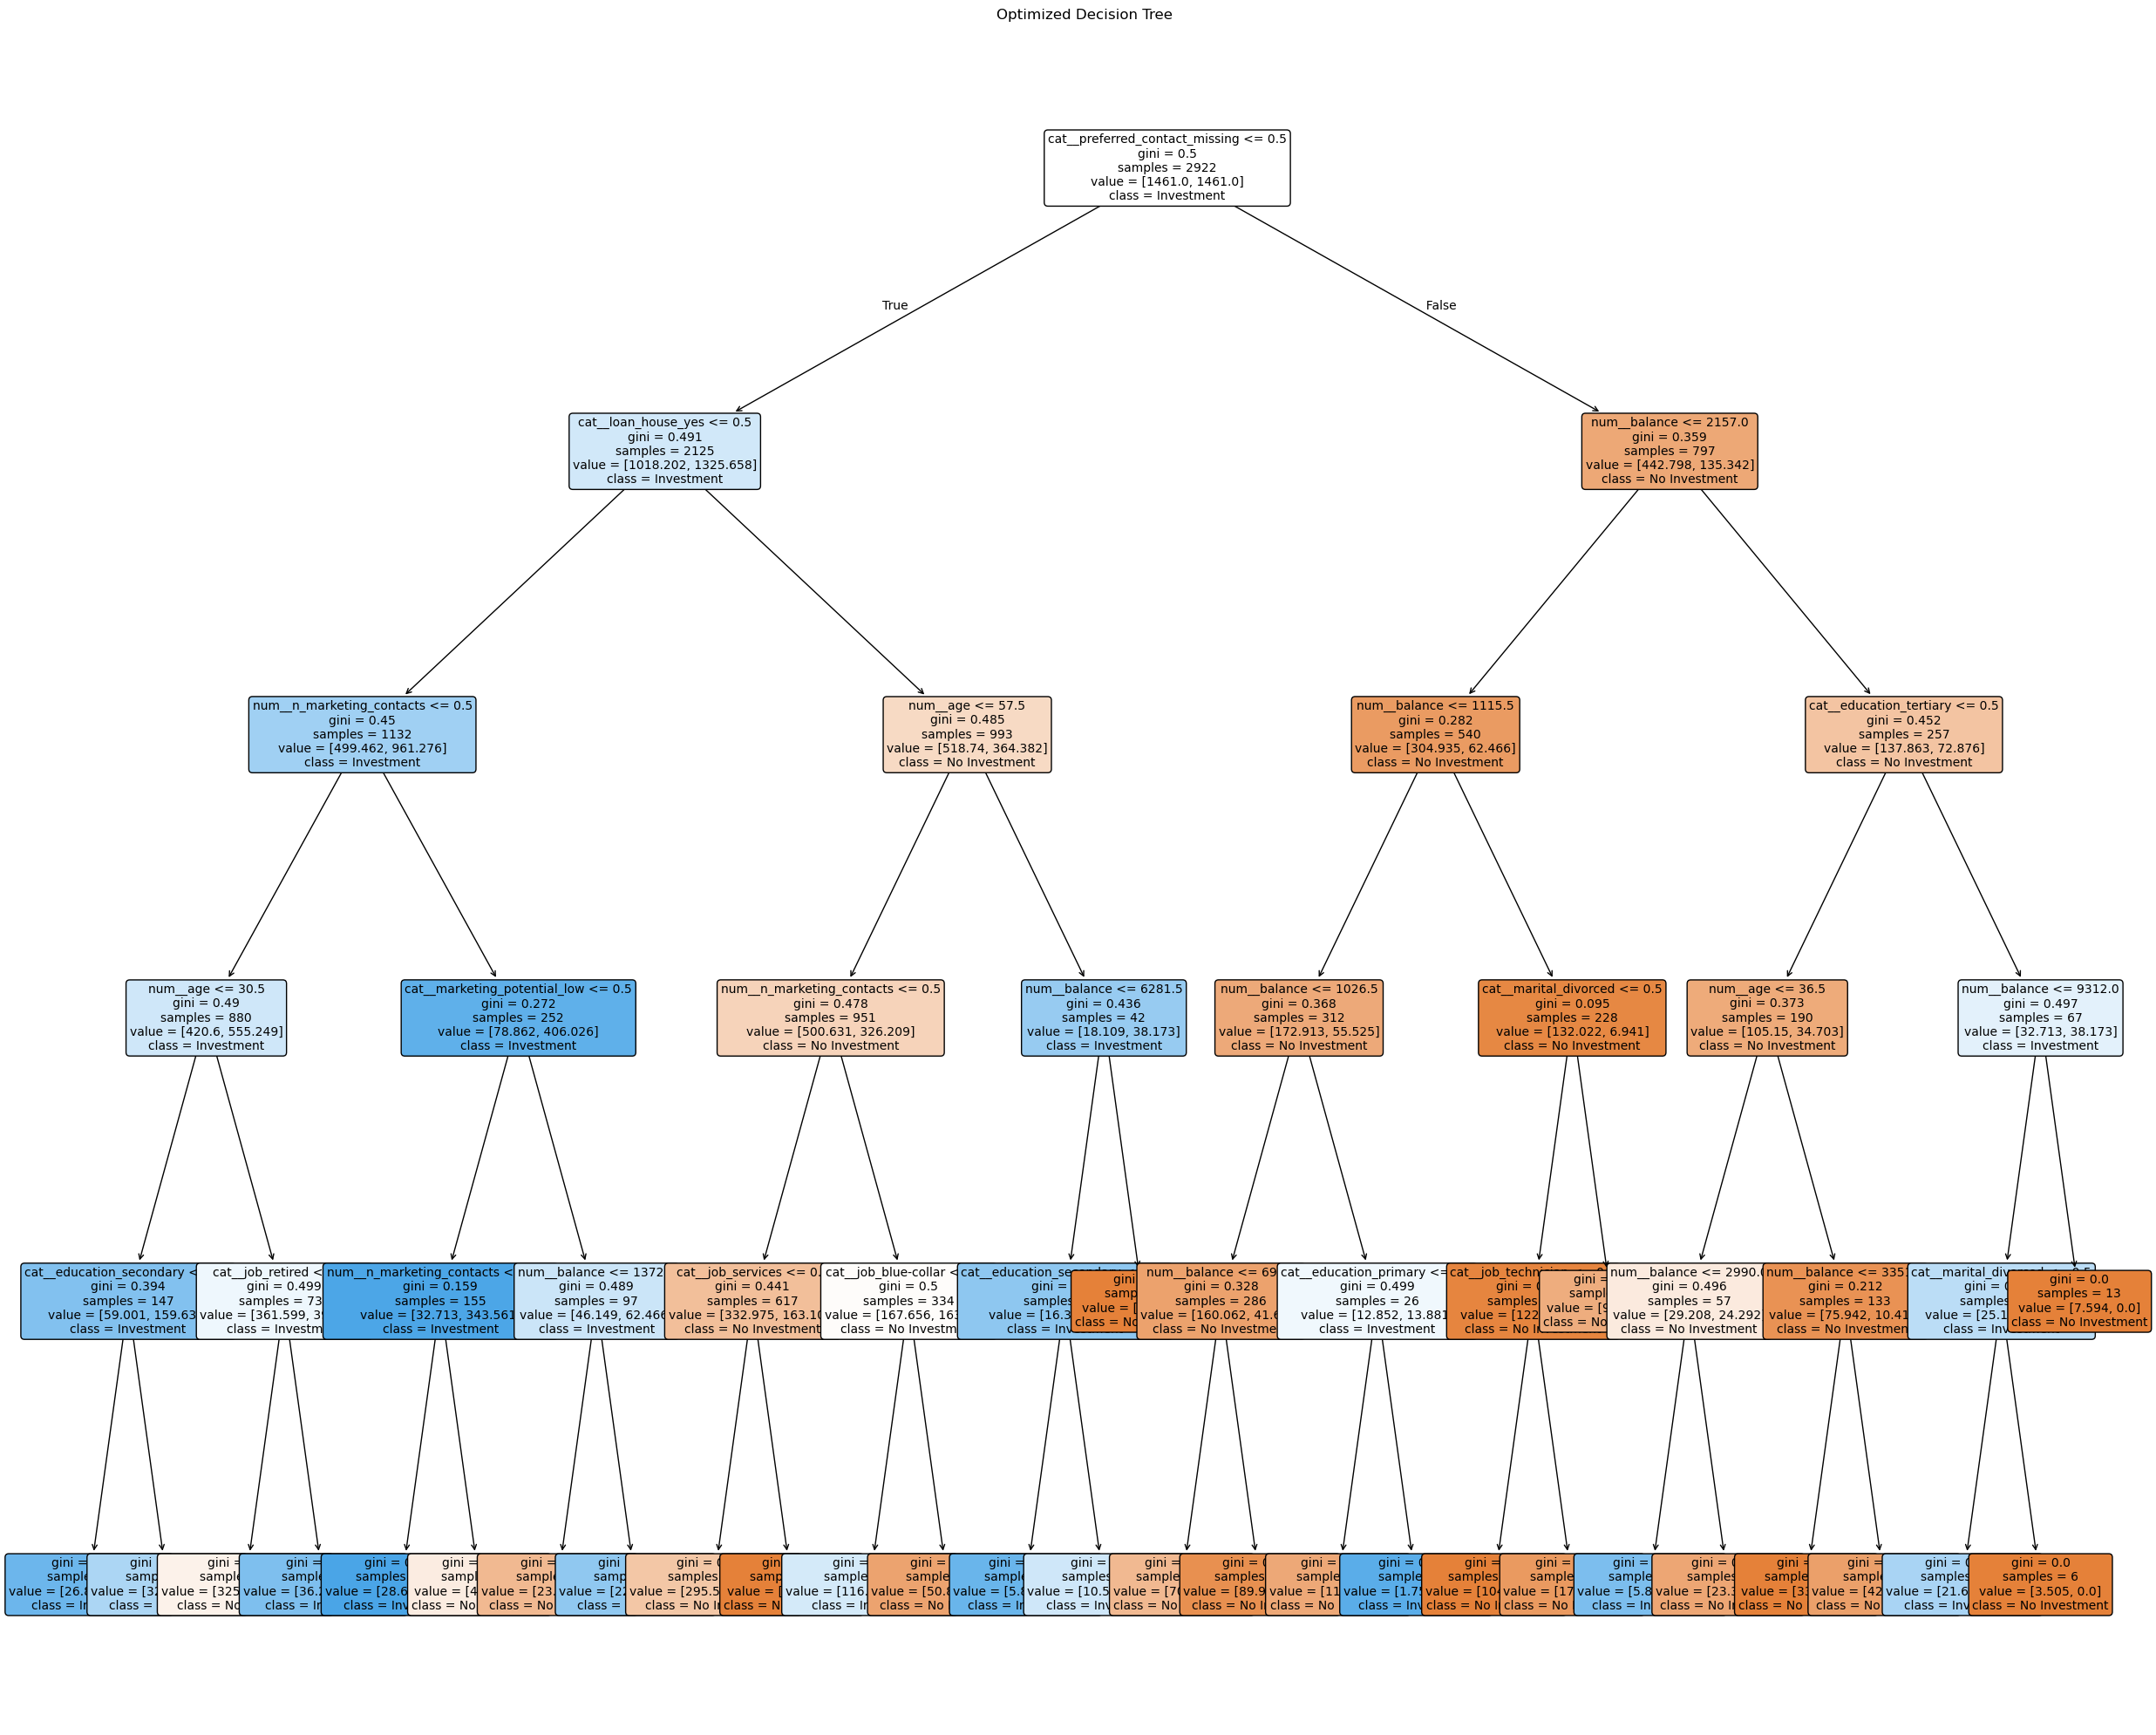

In [22]:
best_tree = cv.best_estimator_.named_steps['classifier']

feature_names_all_dt = cv.best_estimator_.named_steps['preprocess'].get_feature_names_out()
variance_mask_dt = cv.best_estimator_.named_steps['var_filter'].get_support()
selected_features_dt = feature_names_all_dt[variance_mask_dt]

plt.figure(figsize=(25, 20))
tree.plot_tree(best_tree,
               feature_names=selected_features_dt,
               class_names=['No Investment', 'Investment'],
               filled=True,
               rounded=True,
               fontsize=10)
plt.title('Optimized Decision Tree')
plt.tight_layout()
plt.show()

The tree visualization shows the decision rules the model learned. Each node displays the split condition, the number of samples, and the predicted class. Blue nodes lean towards No Investment, orange nodes towards Investment. The limited depth (max_depth=5) keeps the tree interpretable, which is a key advantage over more complex models like Random Forest.

## 14. Prediction on Period 1

The Random Forest model (best ROC-AUC) is applied to the new clients from Period 1. Clients are ranked by their predicted probability of investing, and the top 1,200 are selected for outreach. Clients with a balance below 505 euros are excluded as contacting them is not profitable.

In [23]:
# Reload period 1 data (clean copy)
df_1 = pd.read_csv("period_1_prediction.csv")

# Prepare features (same columns as training)
drop_cols_1 = ['id', 'period']
X_1 = df_1.drop(columns=drop_cols_1)

# Predict probabilities using Random Forest
df_1['probability_of_investment'] = cv_rf.predict_proba(X_1)[:, 1]

# Filter unprofitable clients (balance < 505)
df_1['profitable'] = (df_1['balance'] >= 505).astype(int)
df_1.loc[df_1['profitable'] == 0, 'probability_of_investment'] = 0

# Rank by probability and select top 1200
df_1 = df_1.sort_values('probability_of_investment', ascending=False)
df_1['target'] = 0
df_1.iloc[:1200, df_1.columns.get_loc('target')] = 1

print(f"Total clients: {len(df_1)}")
print(f"Selected for contact: {df_1['target'].sum()}")
print(f"Avg probability (selected): {df_1[df_1['target']==1]['probability_of_investment'].mean():.3f}")
print(f"Avg probability (not selected): {df_1[df_1['target']==0]['probability_of_investment'].mean():.3f}")

Total clients: 7700
Selected for contact: 1200
Avg probability (selected): 0.264
Avg probability (not selected): 0.036


The Random Forest model was applied to 7,700 new clients from Period 1. After ranking all clients by their predicted probability of investing, the top 1,200 were selected for outreach. The selected clients have an average investment probability of 26.4%, which is approximately 7 times higher than the non-selected clients (3.6%). This confirms that the model effectively identifies the most promising clients for contact.

## 15. Submission File

In [24]:
# Create submission file
submission = df_1[['id']].copy()
submission['target'] = df_1['target'].values

print("Target distribution:")
print(submission['target'].value_counts())
print(f"\nFirst rows:")
print(submission.head(10))

# Export
submission.to_csv("submission_period_1.csv", index=False)
print("\nFile saved: submission_period_1.csv")

Target distribution:
target
0    6500
1    1200
Name: count, dtype: int64

First rows:
         id  target
2954  10655       1
3528  11229       1
4238  11939       1
3496  11197       1
1778   9479       1
6986  14687       1
6913  14614       1
5586  13287       1
6843  14544       1
7062  14763       1

File saved: submission_period_1.csv


The submission file contains the client id and the target variable (1 = contact, 0 = do not contact). A total of 1,200 clients are selected for outreach based on their predicted probability of investing.

## 16. Conclusion

This submission uses a classification approach to predict whether a client will invest. Three models were trained and compared: Decision Tree, Logistic Regression, and Random Forest. The Random Forest achieved the highest ROC-AUC (0.715) and was selected as the final model.

Clients with a balance below 505 euros were excluded based on business logic, as the expected revenue from these clients does not cover the outreach cost of 5 euros. The remaining clients were ranked by their predicted probability of investing. The top 1,200 clients were selected for contact, with an average investment probability of 26.4% compared to only 3.6% for non-selected clients.

No investment amounts were modeled, as required by Submission 2. The regression approach to predict investment amounts will be explored in Submission 3.